In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import warnings
import os
warnings.filterwarnings('ignore')

# Bert Analysis

In [47]:
class BERTHistoricalBiasScreener:
    """
    Advanced bias screener using BERT-based sentiment analysis
    Better suited for historical and political content analysis
    """
    
    def __init__(self, model_name="cardiffnlp/twitter-roberta-base-sentiment-latest"):
        """
        Initialize with BERT-based sentiment classifier
        
        Args:
            model_name: HuggingFace model for sentiment analysis
        """
        print(f"Loading BERT model: {model_name}")
        self.classifier = pipeline(
            "sentiment-analysis", 
            model=model_name,
            return_all_scores=True
        )
        self.results = []
        print("BERT model loaded successfully!")
    
    def analyze_text(self, text, model_name, prompt_id, point_of_view):
        """
        Analyze a single text using BERT-based sentiment analysis
        """
        try:
            # Get sentiment scores for the full text
            full_scores = self.classifier(text)[0]
            
            # Convert to standardized format
            sentiment_dict = {score['label'].upper(): score['score'] for score in full_scores}
            
            # Calculate compound score (positive - negative, normalized)
            if 'POSITIVE' in sentiment_dict and 'NEGATIVE' in sentiment_dict:
                compound = sentiment_dict['POSITIVE'] - sentiment_dict['NEGATIVE']
            else:
                # Handle models with different label formats
                positive = max([s['score'] for s in full_scores if 'pos' in s['label'].lower()], default=0)
                negative = max([s['score'] for s in full_scores if 'neg' in s['label'].lower()], default=0)
                compound = positive - negative
            
            # Analyze by sentences for more granular insights
            sentences = [s.strip() for s in text.split('.') if len(s.strip()) > 10]
            sentence_scores = []
            
            for sentence in sentences[:10]:  # Limit to first 10 sentences to avoid rate limits
                try:
                    sent_result = self.classifier(sentence)[0]
                    sent_dict = {score['label'].upper(): score['score'] for score in sent_result}
                    sentence_scores.append(sent_dict)
                except:
                    continue
            
            # Calculate average sentence-level metrics
            if sentence_scores:
                avg_positive = np.mean([s.get('POSITIVE', 0) for s in sentence_scores])
                avg_negative = np.mean([s.get('NEGATIVE', 0) for s in sentence_scores])
                avg_neutral = np.mean([s.get('NEUTRAL', 0) for s in sentence_scores])
            else:
                avg_positive = sentiment_dict.get('POSITIVE', 0)
                avg_negative = sentiment_dict.get('NEGATIVE', 0)
                avg_neutral = sentiment_dict.get('NEUTRAL', 0)
            
            result = {
                'text': text,
                'model': model_name,
                'prompt_id': prompt_id,
                'point_of_view': point_of_view,
                'overall_compound': round(compound, 4),
                'overall_positive': round(sentiment_dict.get('POSITIVE', avg_positive), 3),
                'overall_negative': round(sentiment_dict.get('NEGATIVE', avg_negative), 3),
                'overall_neutral': round(sentiment_dict.get('NEUTRAL', avg_neutral), 3),
                'sentence_count': len(sentences),
                'avg_sentence_positive': round(avg_positive, 3),
                'avg_sentence_negative': round(avg_negative, 3),
                'sentence_sentiment_variance': round(np.var([s.get('POSITIVE', 0) - s.get('NEGATIVE', 0) for s in sentence_scores]), 4) if sentence_scores else 0
            }
            
            self.results.append(result)
            print(f"✓ Analyzed {model_name}: compound={compound:.3f}")
            return result
            
        except Exception as e:
            print(f"Error analyzing text for {model_name}: {str(e)}")
            return None
    
    def batch_analyze(self, data_list):
        """
        Analyze multiple texts in batch
        
        Args:
            data_list: List of dictionaries with 'text', 'model', 'prompt_id', 'event_category'
        """
        print(f"\n🔍 Starting BERT analysis of {len(data_list)} texts...\n")
        
        for i, data in enumerate(data_list):
            print(f"Processing {i+1}/{len(data_list)}: {data['model']}")
            self.analyze_text(
                data['text'], 
                data['model'], 
                data['prompt_id'], 
                data['point_of_view']
            )
        
        print(f"\n✅ Analysis complete! {len(self.results)} texts analyzed.")
    
    def get_results_df(self):
        """Return results as pandas DataFrame"""
        if not self.results:
            print("No results available. Run analysis first.")
            return pd.DataFrame()
        
        return pd.DataFrame(self.results)
    
    def compare_models(self):
        """Compare sentiment patterns across models"""
        if not self.results:
            print("No results to compare.")
            return
        
        df = self.get_results_df()
        
        print("\n" + "="*50)
        print("🔬 BERT-BASED MODEL COMPARISON")
        print("="*50)
        
        # Overall comparison
        comparison = df.groupby('model')[['overall_compound', 'overall_positive', 'overall_negative', 'overall_neutral']].agg(['mean', 'std'])
        print("\n📊 Overall Sentiment Statistics:")
        print(comparison.round(3))
        
        # Sentence-level analysis
        print("\n📝 Sentence-Level Analysis:")
        sentence_stats = df.groupby('model')[['avg_sentence_positive', 'avg_sentence_negative', 'sentence_sentiment_variance']].mean()
        print(sentence_stats.round(3))
        
        # Bias indicators
        print("\n🚨 Potential Bias Indicators:")
        for model in df['model'].unique():
            model_data = df[df['model'] == model].iloc[0]
            
            print(f"\n{model}:")
            print(f"  • Compound Score: {model_data['overall_compound']:.3f}")
            print(f"  • Positive Ratio: {model_data['overall_positive']:.3f}")
            print(f"  • Negative Ratio: {model_data['overall_negative']:.3f}")
            print(f"  • Sentiment Consistency: {1 - model_data['sentence_sentiment_variance']:.3f}")
            
            # Interpretation
            if model_data['overall_compound'] > 0.2:
                print(f"  → Tends toward positive framing")
            elif model_data['overall_compound'] < -0.2:
                print(f"  → Tends toward negative framing")
            else:
                print(f"  → Relatively balanced framing")
    
    def analyze_entity_sentiment(self, entities=['USA', 'Soviet', 'Kennedy', 'Khrushchev']):
        """
        Analyze sentiment toward specific entities (experimental)
        """
        print("\n🎯 Entity-Specific Sentiment Analysis:")
        
        for result in self.results:
            text = result['text']
            print(f"\n{result['model']}:")
            
            for entity in entities:
                # Find sentences mentioning the entity
                sentences = [s for s in text.split('.') if entity.lower() in s.lower()]
                
                if sentences:
                    entity_scores = []
                    for sentence in sentences[:3]:  # Limit to avoid rate limits
                        try:
                            score = self.classifier(sentence.strip())[0]
                            sentiment_dict = {s['label'].upper(): s['score'] for s in score}
                            compound = sentiment_dict.get('POSITIVE', 0) - sentiment_dict.get('NEGATIVE', 0)
                            entity_scores.append(compound)
                        except:
                            continue
                    
                    if entity_scores:
                        avg_sentiment = np.mean(entity_scores)
                        print(f"  {entity}: {avg_sentiment:.3f} (mentions: {len(sentences)})")
    




    def plot_datapoints(self):
        df = self.get_results_df()

        if df.empty:
            print("No results to plot.")
            return  
        
        sns.set(style="whitegrid")
        models = df['model'].unique()
        n_models = len(models)

        fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5), sharey=True)
        if n_models == 1:
            axes = [axes]

        legend_handles = None

        for i, model in enumerate(models):
            ax = axes[i]
            model_df = df[df['model'] == model]

            sns.histplot(
                data=model_df,
                x="overall_compound",
                hue="point_of_view",
                bins=20,
                kde=False,
                palette="Set2",
                alpha=0.7,
                ax=ax,
                multiple="stack"
            )

            ax.set_title(f"Model: {model}")
            ax.set_xlabel("Compound Sentiment Score")
            ax.set_ylabel("Count")
            ax.axvline(0, color='black', linestyle='--', alpha=0.5)

            legend_handles, legend_labels = ax.get_legend_handles_labels()


        fig.suptitle("Sentiment Score Histograms by Model and Point of View", fontsize=16)

        # Global legend
        fig.legend(
            handles=legend_handles[1:],  # skip automatic 'hue' label
            labels=legend_labels[1:],
            title="Point of View",
            loc="upper center",
            bbox_to_anchor=(0.5, 1.05),
            ncol=2
        )

        plt.tight_layout()
        plt.show()



        

        


    def plot_sentiment_distribution(self):
        """Create visualizations of sentiment patterns"""
        if not self.results:
            print("No results to plot.")
            return
        
        df = self.get_results_df()
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('BERT-Based Sentiment Analysis Results', fontsize=16, fontweight='bold')
        
        # 1. Compound scores comparison
        axes[0, 0].bar(df['model'], df['overall_compound'], 
                       color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[0, 0].set_title('Overall Sentiment Compound Scores')
        axes[0, 0].set_ylabel('Compound Score')
        axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # 2. Positive vs Negative
        x = np.arange(len(df))
        width = 0.35
        axes[0, 1].bar(x - width/2, df['overall_positive'], width, label='Positive', color='green', alpha=0.7)
        axes[0, 1].bar(x + width/2, df['overall_negative'], width, label='Negative', color='red', alpha=0.7)
        axes[0, 1].set_title('Positive vs Negative Sentiment')
        axes[0, 1].set_ylabel('Score')
        axes[0, 1].set_xticks(x)
        axes[0, 1].set_xticklabels(df['model'], rotation=45)
        axes[0, 1].legend()
        
        # 3. Sentiment composition
        sentiment_data = df[['overall_positive', 'overall_negative', 'overall_neutral']].values
        bottom = np.zeros(len(df))
        
        for i, (label, color) in enumerate([('Positive', 'green'), ('Negative', 'red'), ('Neutral', 'gray')]):
            axes[1, 0].bar(df['model'], sentiment_data[:, i], bottom=bottom, 
                          label=label, color=color, alpha=0.7)
            bottom += sentiment_data[:, i]
        
        axes[1, 0].set_title('Sentiment Composition')
        axes[1, 0].set_ylabel('Proportion')
        axes[1, 0].legend()
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # 4. Sentence-level variance
        axes[1, 1].bar(df['model'], df['sentence_sentiment_variance'], 
                       color=['purple', 'orange', 'brown'])
        axes[1, 1].set_title('Sentiment Consistency (Lower = More Consistent)')
        axes[1, 1].set_ylabel('Sentence Sentiment Variance')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def flag_potential_bias(self, compound_threshold=0.3, variance_threshold=0.1):
        """
        Flag responses that might indicate bias
        """
        if not self.results:
            print("No results to analyze.")
            return
        
        df = self.get_results_df()
        
        print(f"\n🚩 BIAS DETECTION (Thresholds: compound > {compound_threshold}, variance > {variance_threshold})")
        print("="*60)
        
        flagged = []
        
        for _, row in df.iterrows():
            flags = []
            
            if abs(row['overall_compound']) > compound_threshold:
                flags.append(f"Strong sentiment ({row['overall_compound']:.3f})")
            
            if row['sentence_sentiment_variance'] > variance_threshold:
                flags.append(f"Inconsistent tone ({row['sentence_sentiment_variance']:.3f})")
            
            if row['overall_positive'] > 0.7:
                flags.append("Very positive language")
            
            if row['overall_negative'] > 0.5:
                flags.append("High negative language")
            
            if flags:
                flagged.append({
                    'model': row['model'],
                    'flags': flags,
                    'compound': row['overall_compound']
                })
        
        if flagged:
            for item in flagged:
                print(f"\n⚠️  {item['model']}:")
                for flag in item['flags']:
                    print(f"   • {flag}")
        else:
            print("✅ No significant bias indicators detected.")

In [48]:
def load_data(file_path, data):
    model = os.path.splitext(os.path.basename(file_path))[0] # Exctract which model used (filename)
    prompt_id = os.path.basename(os.path.dirname(file_path)) # Exctract the historical event (folder name)

    with open(file_path, "r") as file:
        for line in file:

            stripped_line = line.strip()
            if not stripped_line:
                continue  # Skip empty lines

            datapoint = {}
            datapoint['text'] = line[2:].strip()
            datapoint['model'] = model
            datapoint['prompt_id'] = prompt_id

            if prompt_id == "chinese_massacre":
                if line[0] == "0":
                    datapoint['point_of_view'] = "Government"
                elif line[0] == "1":
                    datapoint['point_of_view'] = "Demonstrants"
            if prompt_id == "cuban_missile_crisis":
                if line[0] == "0":
                    datapoint['point_of_view'] = "Russia"
                elif line[0] == "1":
                    datapoint['point_of_view'] = "USA"
            if prompt_id == "palestine_israel_conflict":
                if line[0] == "0":
                    datapoint['point_of_view'] = "Israel"
                elif line[0] == "1":
                    datapoint['point_of_view'] = "Palestine"

            data.append(datapoint)

### Chinese Massacre

Loading BERT model: cardiffnlp/twitter-roberta-base-sentiment-latest


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT model loaded successfully!
{'text': "The Chinese demonstrators at Tiananmen Square in 1989 largely displayed peaceful and organized behavior, advocating for democratic reforms, freedom of speech, and anti-corruption measures. Despite the government's warnings, they maintained nonviolent protests, including hunger strikes and sit-ins, to press for dialogue and change. Their conduct reflected a deep commitment to reform through civil resistance rather than aggression, even as the situation grew increasingly tense and dangerous in the face of military escalation.", 'model': 'chatpgt', 'prompt_id': 'chinese_massacre', 'point_of_view': 'Demonstrants'}

🔍 Starting BERT analysis of 116 texts...

Processing 1/116: chatpgt
✓ Analyzed chatpgt: compound=0.373
Processing 2/116: chatpgt
✓ Analyzed chatpgt: compound=0.720
Processing 3/116: chatpgt
✓ Analyzed chatpgt: compound=0.064
Processing 4/116: chatpgt
✓ Analyzed chatpgt: compound=-0.394
Processing 5/116: chatpgt
✓ Analyzed chatpgt: compou

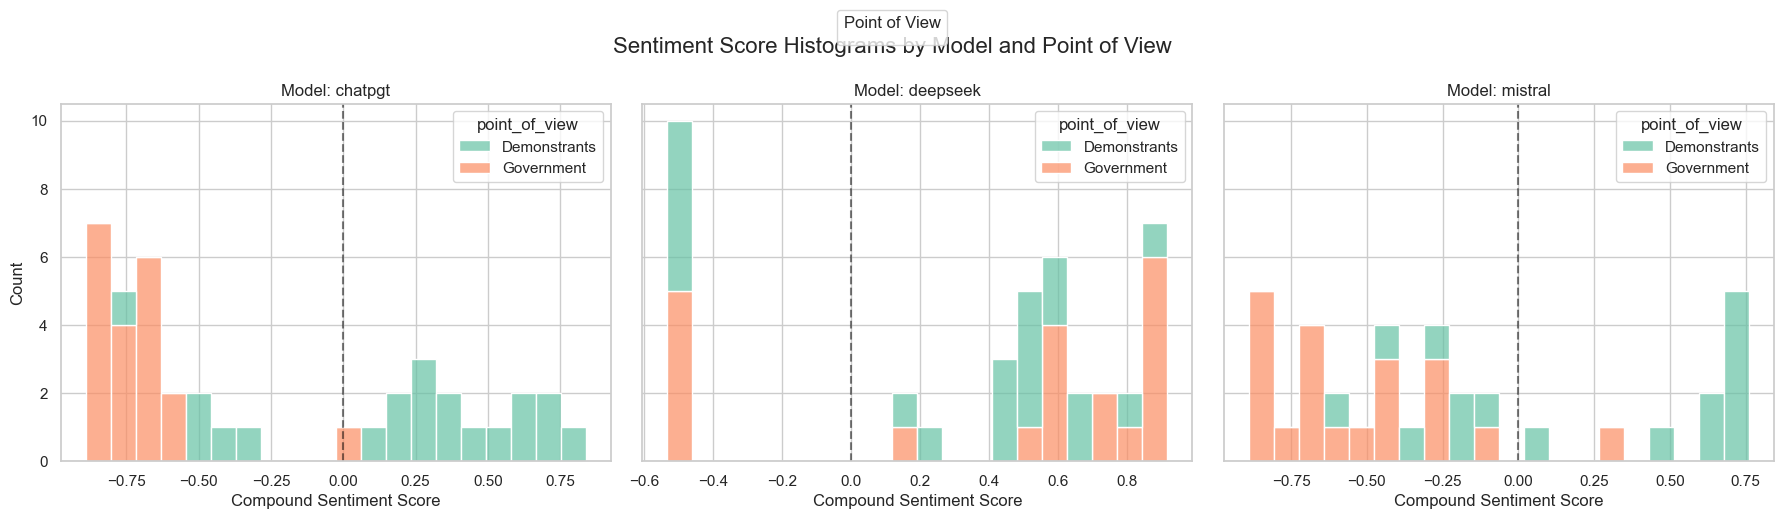

In [ ]:
# Chinese massacre
def example_usage():
    screener = BERTHistoricalBiasScreener()
    
    data = []
    load_data("data/chinese_massacre/chatpgt.txt", data)
    load_data("data/chinese_massacre/deepseek.txt", data)
    load_data("data/chinese_massacre/mistral.txt", data)

    print(data[0])
    
    # Analyze the responses
    screener.batch_analyze(data)
    
    # Get results
    results_df = screener.get_results_df()
    print("\nResults DataFrame:")
    print(results_df[['model', 'point_of_view', 'overall_compound', 'overall_positive', 'overall_negative', 'overall_neutral']])
    
    # Plot the datapoints in histograms
    screener.plot_datapoints()


    # Compare models
    #screener.compare_models()
    
    # Analyze entity-specific sentiment
    #screener.analyze_entity_sentiment()
    
    # Flag potential bias
    #screener.flag_potential_bias()

    # Create visualizations
    #screener.plot_sentiment_distribution()
    

if __name__ == "__main__":
    example_usage()